# Intro

В данной работе мы разбираемся как ведут себя пользователи мобильного приложения по продаже продуктов питания.<br>
Изучим воронку продаж. <br>
Узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах.<br>
После этого исследуем результаты A/A/B-эксперимента. Дизайнеры предложили поменять шрифты во всём приложении.<br>
Принимать решение стоит ли изменять шрифт будем по результатам A/A/B-теста.<br>
Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.<br>
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, то мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.<br><br>
**Описание данных:**
 - EventName — название события;
 - DeviceIDHash — уникальный идентификатор пользователя;
 - EventTimestamp — время события;
 - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Шаг 1. Изучаем данные

### Загружаем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from datetime import datetime, timedelta
import scipy.stats as stats
import math as mth
import os
import numpy as np
import scipy.stats as st
pd.set_option('display.max_columns', 50)
from pandas.plotting import register_matplotlib_converters
import warnings

### Загружаем датасет

In [2]:
pth1 = 'datasets/logs_exp.csv'
if os.path.exists(pth1):
    logs = pd.read_csv(pth1, sep='\t')
else:
    print('Something is wrong')

In [3]:
logs.info()
display(logs.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


# Шаг 2. Подготавливаем данные

### Заменим названия столбцов

In [31]:
logs.rename(columns = {'EventName':'event_name', 'DeviceIDHash':'device_id_hash', 'EventTimestamp':'event_timestamp', 'ExpId':'exp_id'}, inplace = True)

### Проверим пропуски и типы данных

In [5]:
print(logs.isnull().sum())

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64


**Пропусков нет**

In [6]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Типы данных оставляем как есть. Под дату добавим новые столбцы.

### Добавим два столбца: первый - дата и время, второй - дата.

In [7]:
logs['date_time'] = logs['event_timestamp'].apply(datetime.fromtimestamp)
logs['date'] = pd.to_datetime(logs['date_time'].dt.date)
logs.info()
display(logs.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   exp_id           244126 non-null  int64         
 4   date_time        244126 non-null  datetime64[ns]
 5   date             244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 07:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 14:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 14:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 14:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 14:48:42,2019-07-25
5,CartScreenAppear,6217807653094995999,1564055323,248,2019-07-25 14:48:43,2019-07-25
6,OffersScreenAppear,8351860793733343758,1564066242,246,2019-07-25 17:50:42,2019-07-25
7,MainScreenAppear,5682100281902512875,1564085677,246,2019-07-25 23:14:37,2019-07-25
8,MainScreenAppear,1850981295691852772,1564086702,247,2019-07-25 23:31:42,2019-07-25
9,MainScreenAppear,5407636962369102641,1564112112,246,2019-07-26 06:35:12,2019-07-26


**Проверим данные на дубликаты**

In [8]:
print('Повторяющихся строк в orders:', logs.duplicated().sum())

Повторяющихся строк в orders: 413


Удалим дубликаты:

In [9]:
logs = logs.drop_duplicates()
print('Повторяющихся строк в orders:', logs.duplicated().sum())

Повторяющихся строк в orders: 0


**Проверим попадание пользователей сразу в несколько групп**

In [10]:
set_246 = set(logs['device_id_hash'][logs['exp_id'] == 246].unique().tolist())
set_247 = set(logs['device_id_hash'][logs['exp_id'] == 247].unique().tolist())
set_248 = set(logs['device_id_hash'][logs['exp_id'] == 248].unique().tolist())
print('Пересекающихся пользователей в группах:', len(set_247 & set_248 & set_246))

Пересекающихся пользователей в группах: 0


**Мы провели предобработку данных**
 - исправили названия столбцов, 
 - добавили новые столбцы с датой и временем и только датой, 
 - проверили пропуски и типы данных, 
 - нашил и удалили дубликаты строк, 
 - а также проверили, не входят ли одни и те же пользователи в разные группы.

# Шаг 3. Изучим и проверим данные

In [11]:
print('Всего в логе', logs.shape[0], 'событий.')

Всего в логе 243713 событий.


In [12]:
print('Всего в логе', logs['device_id_hash'].nunique(), 'пользователей.')

Всего в логе 7551 пользователей.


In [13]:
print('В среднем на пользователя приходится', round(logs.shape[0] / logs['device_id_hash'].nunique()), 'событий.')

В среднем на пользователя приходится 32 событий.


In [14]:
print('Мы имеем данные за период с', logs['date_time'].min(), 'по', logs['date_time'].max())

Мы имеем данные за период с 2019-07-25 07:43:36 по 2019-08-08 00:15:17


**Изучим, как меняется количество данных**

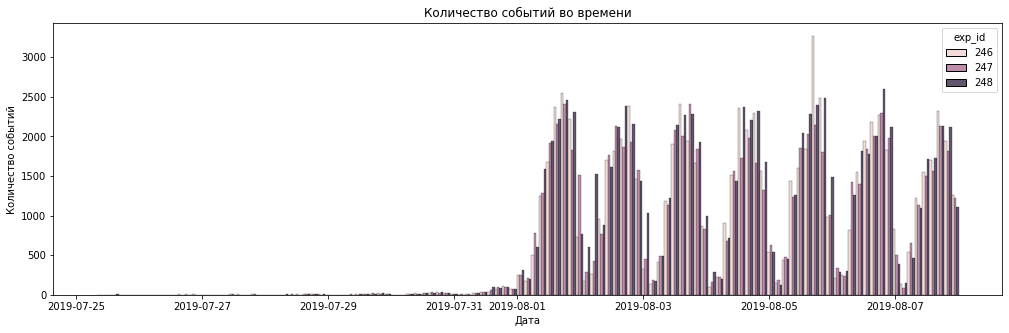

In [15]:
plt.rcParams["figure.figsize"] = (17,5)

sns.histplot(data=logs, x="date_time", hue="exp_id", multiple="dodge")

plt.title('Количество событий во времени')
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.show()

None

**На графике видно, что основные данные у нас появляются только с 01.08.2019. Отбросим данные ранее 01.08.2019.**

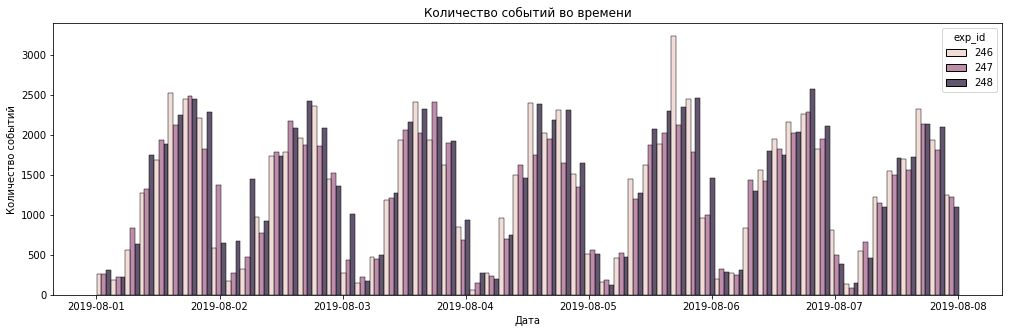

In [32]:
logs_act = logs.query('date >= "2019-08-01"')

sns.histplot(data=logs_act, x="date_time", hue="exp_id", multiple="dodge")

plt.title('Количество событий во времени')
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.show()
None

In [17]:
print('Фактически мы распологаем данными за период с', logs_act['date_time'].min(), 'по', logs_act['date_time'].max())

Фактически мы распологаем данными за период с 2019-08-01 00:00:57 по 2019-08-08 00:15:17


In [18]:

print('В итоге мы потеряли', 
      logs['device_id_hash'].nunique() - logs_act['device_id_hash'].nunique(), '(',
      round((logs['device_id_hash'].nunique() - logs_act['device_id_hash'].nunique()) / logs['device_id_hash'].nunique() * 100, 2), '%)', 
      'пользователей и', logs['event_name'].count() - logs_act['event_name'].count(), '(',
      round((logs['event_name'].count() - logs_act['event_name'].count()) / logs['event_name'].count() * 100, 2), '%)', 'событий.')

В итоге мы потеряли 13 ( 0.17 %) пользователей и 1989 ( 0.82 %) событий.


**Потери незначительны**

**Проверим, что у нас в данных после среза есть пользователи из всех трех групп.**

In [19]:
print(logs_act.groupby(by='exp_id').agg({'device_id_hash': 'nunique'}))

        device_id_hash
exp_id                
246               2484
247               2517
248               2537


Пользователи всех трех групп в нашем распоряжении.

# Шаг 4. Изучаем воронку событий

## Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [20]:
event_list = logs_act.groupby(by='event_name')['event_name'].agg({'count'}).sort_values(by='count', ascending=False)
event_list

,count
event_name,
MainScreenAppear,117889
OffersScreenAppear,46531
CartScreenAppear,42343
PaymentScreenSuccessful,33951
Tutorial,1010


 - Открытие главной страницы 117992
 - Открытие страницы оффера 46548
 - Открытие страницы корзины 42406
 - Оплата прошла 34146
 - Открытие обучающей страницы 1044

## Посчитаем, сколько пользователей совершали каждое из этих событий.

In [21]:
users_by_event = logs_act.groupby('event_name').agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)
users_by_event
users_by_event['share'] = users_by_event['device_id_hash'] / logs_act['device_id_hash'].nunique() * 100 # Посчитаем долю пользователей, которые хоть раз совершали событие.
users_by_event = users_by_event.query('event_name != "Tutorial"')
users_by_event

,device_id_hash,share
event_name,,
MainScreenAppear,7423,98.474396
OffersScreenAppear,4597,60.984346
CartScreenAppear,3736,49.562218
PaymentScreenSuccessful,3540,46.962059


**Около 1,5% пользователей миновали главный экран. Причиной может быть переход сразу на страницу оффера с лэндингов или по прямой ссылке** 


**Событие Tutorial следует исключить из воронки событий, так как в Обучающие материалы скорее всего можно перейти только с главной страницы. А в остальном события выстроились в логическом порядке.**

**Посчитаем, какой процент пользователей остается на каждом этапе воронки относительно предыдущего этапа.**

In [22]:
users_by_event['share_by_step'] = round(users_by_event['device_id_hash'] / users_by_event['device_id_hash'].shift(1) *100,)
users_by_event['share_by_step'] = users_by_event['share_by_step'].fillna (100)
users_by_event

,device_id_hash,share,share_by_step
event_name,,,
MainScreenAppear,7423,98.474396,100.0
OffersScreenAppear,4597,60.984346,62.0
CartScreenAppear,3736,49.562218,81.0
PaymentScreenSuccessful,3540,46.962059,95.0


**Больше всего пользователей теряем при переходе с главной страницы на страницу с оффером.**

**Посчитаем долю пользователей, которая от первого события доходит до оплаты**

In [23]:
main_to_pay = round(users_by_event['device_id_hash'].min() / users_by_event['device_id_hash'].max() *100)
print(main_to_pay)

48


**С главной страницы доходит до оплаты 48% пользователей**

### Общий вывод по анализу воронки и конверсии:
 - Больше всего теряется пользователей при переходе с главной страницы на страницу оффера,
 - Также 19% пользователей теряется на этапе перехода в корзину,
 - А у 5% пользователей возникают проблемы с оплатой.<br>
 
**Рекомендации:**
1. Проверить интерфейс и корректность работы приложения при переходе из главной страницы на стреницу оффера.
2. Улучшить страницу оффера.
3. Проверить логи с ошибками по оплате, возможно есть технические проблемы.

# Шаг 5. Изучаем результаты эксперимента

## Количество пользователей в каждой экспериментальной группе

In [24]:
cnt_users_by_group = logs_act.groupby('exp_id')['device_id_hash'].nunique()
cnt_users_by_group['246+247'] = cnt_users_by_group[246] + cnt_users_by_group[247]
cnt_users_by_group

exp_id
246        2484
247        2517
248        2537
246+247    5001
Name: device_id_hash, dtype: int64

## Есть ли разница в статистических критериях между выборками 246 и 247.

In [25]:
users_by_group = logs_act.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')

users_by_group = users_by_group.sort_values(by=246, ascending=False)
users_by_group = users_by_group.query('event_name != "Tutorial"')
users_by_group = users_by_group.reset_index()
users_by_group['246+247'] =  users_by_group[246] + users_by_group[247]
users_by_group

exp_id,event_name,246,247,248,246+247
0,MainScreenAppear,2450,2479,2494,4929
1,OffersScreenAppear,1542,1524,1531,3066
2,CartScreenAppear,1266,1239,1231,2505
3,PaymentScreenSuccessful,1200,1158,1182,2358


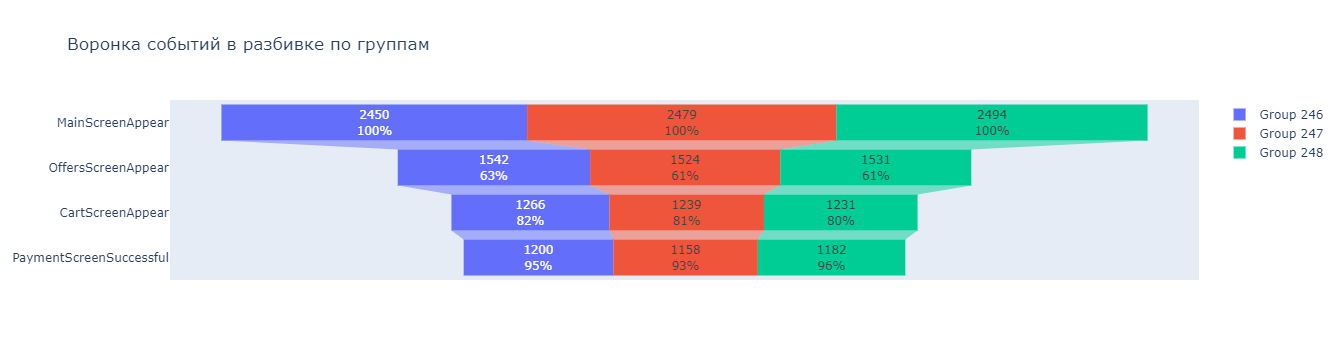

In [34]:
fig = go.Figure()
fig.update_layout(title={'text': "Воронка событий в разбивке по группам"})

fig.add_trace(go.Funnel(
    name = 'Group 246',
    orientation = "h",
    y = users_by_group['event_name'],
    x = users_by_group[246],
    textposition = "inside",
    textinfo = "value+percent previous"))
fig.add_trace(go.Funnel(
    name = 'Group 247',
    orientation = "h",
    y = users_by_group['event_name'],
    x = users_by_group[247],
    textposition = "inside",
    textinfo = "value+percent previous"))
fig.add_trace(go.Funnel(
    name = 'Group 248',
    orientation = "h",
    y = users_by_group['event_name'],
    x = users_by_group[248],
    textposition = "inside",
    textinfo = "value+percent previous"))
fig.show()

**Сравним две выборки из группы 246 и группы 247**

В работе будем использовать проверку гипотезы о равенстве долей (z-test).
Сформулируем гипотезы:<br>
H0: Между группами нет значимой разницы<br>
H1: Между группами есть значимая разница<br>
Так как мы сравниваем две контрольные группы, то уровень статистической значимости примем за 0.01

In [27]:
def test(group1, group2, alpha):
    for i in users_by_group.index:
        p1 = users_by_group[group1][i]/cnt_users_by_group[group1]
        p2 = users_by_group[group2][i]/cnt_users_by_group[group2]
        
        p_combined = (users_by_group[group1][i] + users_by_group[group2][i]) / (cnt_users_by_group[group1] + cnt_users_by_group[group2])
        difference = p1 - p2

        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/cnt_users_by_group[group1] + 1/cnt_users_by_group[group2]))
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('p-значение: ', p_value)
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            )
        print()
            
test(246,247,0.01)

p-значение:  0.6756217702005545
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.26698769175859516
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.2182812140633792
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.10298394982948822
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Итак, разбиение на группы A1 и A2 работает корректно. Можно приступать к А/B тесту**

## Сравним результаты экспериментальной группы с каждой из контрольных групп.

Сформулируем гипотезы:<br>
H0: Между группами нет значимой разницы<br>
H1: Между группами есть значимая разница<br>
Уровень статистической значимости также примем за 0.01

**Сравниваем группу 246 с 248**

In [28]:
test(246,248,0.01)

p-значение:  0.34705881021236484
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.08328412977507749
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.22269358994682742
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Сравниваем группу 247 с 248**

In [29]:
test(247,248,0.01)

p-значение:  0.6001661582453706
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.8835956656016957
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.6169517476996997
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.6775413642906454
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Сравниваем объединенные группы 246 и 247 с 248**

In [30]:
test('246+247', 248, 0.01)

p-значение:  0.39298914928006035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.418998284007599
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.19819340844527744
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение:  0.6452057673098244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**На основании проведенных тестов, можно сделать вывод, что изменение шрифта не дало ощутимых результатов**
 - Изначально мы приняли для всех тестов уровень значимости в размере 0,05. Везде результат был один, что нет оснований считать доли разными.
 - Далее мы уменьшили уровень значимости до 0,01 (при таком уровне лишь в 1% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна). Результат не изменился, нет оснований считать доли разными.
 - На основании вышеизложенного считаем, что уровень значимости в 0,01 допустимый и достаточный для проверок такого уровня, нет необходимости дальше изменять уровень значимости.

# Общий вывод

**Вывод по A/B-тесту**
 - На основании анализа А/В-тестов изменение шрифтов в приложении не приведет к положительным результатам по увеличению конверсии.
 
**Вывод по анализу воронки и конверсии:**
 - Больше всего теряется пользователей при переходе с главной страницы на страницу оффера -38%
 - Также 19% пользователей теряется на этапе перехода в корзину
 - А у 5% пользователей возникают проблемы с оплатой<br>
 
**Рекомендации по улучшению конверсии**
 - Проверить интерфейс и корректность работы приложения при переходе из главной страницы на стреницу оффера
 - Улучшить страницу оффера
 - Проверить логи с ошибками по оплате, возможно есть технические проблемы